# Imports

In [ ]:
# from prepare_data import sayhello

# ss = sayhello()
# print(ss)

In [1]:
import sqlite3
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

SQL_LITE_DB_PATH = "D:\\Repos\\ut-health\\mimic-iii-gz\\mimic3.db"

# Connect to the SQLite database in the file at the given path d:\data\mimic.db
conn = sqlite3.connect(SQL_LITE_DB_PATH)

# print version of sqlite
cursor = conn.cursor()
cursor.execute("SELECT sqlite_version()")
print("SQLite version: %s" % cursor.fetchone())

# close connection
conn.close()

# print pandas version
print("Pandas version: %s" % pd.__version__)

# print matplotlib version
print(f"Matplotlib version: {matplotlib.__version__}")

print(f"NetworkX version: {nx.__version__}")

# Set pandas display options to show all columns and rows without truncation
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
print("\nRemoved truncation of columns")


SQLite version: 3.49.1
Pandas version: 2.2.3
Matplotlib version: 3.10.1
NetworkX version: 3.4.2

Removed truncation of columns


# Load Data

In [2]:
# load patient data
conn = sqlite3.connect(SQL_LITE_DB_PATH)

query = "SELECT * FROM patients"
patients_df = pd.read_sql_query(query, conn)

query = "SELECT * FROM d_icd_diagnoses"
d_icd_diagnoses_df = pd.read_sql_query(query, conn)

query = "SELECT * FROM diagnoses_icd"
diagnoses_icd_df = pd.read_sql_query(query, conn)

query = "SELECT * FROM admissions"
admissions_df = pd.read_sql_query(query, conn)

conn.close()

# Subselect size of data
Reduces the number of patients, picks the latest admission (hadm_id) for the patient and picks only those diagnoses belonging to the hospital admission.

In [3]:
# print the number of patients and diagnoses
print(f"Number of patients: {len(patients_df)}")
print(f"Number of diagnoses: {len(diagnoses_icd_df)}")
print(f"Number of admissions: {len(admissions_df)}")

pt_frac = 0.0001  # 0.01% of the patients gives 5 patients, 52 diagnoses
pt_frac = 0.0002  # 0.02% of the patients gives 9 patients, 110 diagnoses
pt_frac = 0.0003  # 0.02% of the patients gives 14 patients, 188 diagnoses
pt_frac = 0.0015  # 0.02% of the patients gives 14 patients, 188 diagnoses

# select 0.01% of the patients randomly
patients_df = patients_df.sample(frac=pt_frac, random_state=1)

# add DOB to admissions_df
admissions_df = admissions_df.merge(patients_df[['SUBJECT_ID', 'DOB']], left_on='SUBJECT_ID', right_on='SUBJECT_ID', how='inner', suffixes=('_adm', '_pt'))

# sort admissions_df by SUBJECT_ID and ADMITTIME in ascending order
admissions_df['ADMITTIME'] = pd.to_datetime(admissions_df['ADMITTIME'])
admissions_df = admissions_df.sort_values(by=['SUBJECT_ID', 'ADMITTIME'])

# keep the newest admission (HADM_ID) for each patient, drop the rest of the admissions
admissions_df = admissions_df.groupby('SUBJECT_ID').last().reset_index()

# keep only diagnoses that belong to HADM_IDs in admissions_df
diagnoses_icd_df = diagnoses_icd_df[diagnoses_icd_df['HADM_ID'].isin(admissions_df['HADM_ID'])]

# print the number of patients and diagnoses
print(f"Updated number of patients: {len(patients_df)}")
print(f"Updated number of diagnoses: {len(diagnoses_icd_df)}")
print(f"Updated number of admissions: {len(admissions_df)}")

# TODO: fix the HADM_ID issue, only keep diagnosies that are from the latest admissions under subject id, and drop the rest, do same for admissions_df

Number of patients: 46520
Number of diagnoses: 651047
Number of admissions: 58976
Updated number of patients: 70
Updated number of diagnoses: 813
Updated number of admissions: 70


# Feature Engineering
Adds age bucket feature and hadm_id to patient dataframe

In [4]:
# log data
print(f"Number of patients: {len(patients_df)}")

# convert to integer from datetime type to calculate age (without overflow)
admissions_df['DOB'] = admissions_df['DOB'].astype('datetime64[s]').astype(int)
admissions_df['ADMITTIME'] = admissions_df['ADMITTIME'].astype('datetime64[s]').astype(int)

# calculate age at admission
admissions_df['AGE'] = (admissions_df['ADMITTIME'] - admissions_df['DOB']) / 86400 / 365

# create age intervals in 5 year increments, of type int
admissions_df['AGE_BUCKET'] = (admissions_df['AGE'] // 5).astype(int) * 5

# set age bucket to 95 where age is greater than 90
admissions_df.loc[admissions_df['AGE_BUCKET'] > 90, 'AGE_BUCKET'] = 95

# add AGE_BUCKET to patients_df
patients_df = patients_df.merge(admissions_df[['SUBJECT_ID', 'HADM_ID', 'AGE_BUCKET']], left_on='SUBJECT_ID', right_on='SUBJECT_ID', how='inner', suffixes=('_pt', '_adm'))

print(f"Updated number of patients (with age bucket): {len(patients_df)}")

Number of patients: 70
Updated number of patients (with age bucket): 70


In [ ]:
patients_df.head(5)

# Create Graph

## Create patient nodes

In [5]:
# Create a graph
G = nx.Graph()

i = 0

for _, row in patients_df.iterrows():

    # Add a node with the patient ID as the node identifier and gender as an attribute, also add dob as an attribute
    G.add_node(row['SUBJECT_ID'], gender=row['GENDER'], age=row['DOB'], age_bucket=row['AGE_BUCKET'], hadm_id=row['HADM_ID'])

    i+=1
    if i % 2000 == 0:
        print(f"Added {i} patient nodes, percent: {i / len(patients_df) * 100:.2f}%")

# number of nodes in the graph
print(f"Number of nodes in the graph: {G.number_of_nodes()}")

Number of nodes in the graph: 70


## Create diagnosis to patient mappings

In [6]:
# group diagnoses by icd9 codes, and create a dictionary with each icd9 code as the key and the subject_ids as the values
diagnoses_to_patients = diagnoses_icd_df.groupby('ICD9_CODE')['SUBJECT_ID'].apply(set).to_dict()

# print 1 random key and value from the dictionary
print(f"Sample keys and values from the dictionary:")
print(f"\t\t{list(diagnoses_to_patients.items())[12]}")
print(f"\t\t{list(diagnoses_to_patients.items())[15]}")

# print size of the dictionary and counts of values
print(f"Count of the number of keys (icd9s) in the dictionary: {len(diagnoses_to_patients)}")
print(f"Count of the number of values (subject_ids) in all keys: {sum(len(v) for v in diagnoses_to_patients.values())}")

Sample keys and values from the dictionary:
		('07032', {59977})
		('1532', {83422})
Count of the number of keys (icd9s) in the dictionary: 453
Count of the number of values (subject_ids) in all keys: 812


### Validation code

In [7]:
# Validation
unique_subject_ids = len(set([item for sublist in diagnoses_to_patients.values() for item in sublist]))

# count number of unique subject_ids across all values in the dictionary
print(f"Count of the number of unique subject_ids across all keys: {unique_subject_ids}")

# print number of patients with diagnosis 0389
print(f"Number of patients with diagnosis 0389: {len(diagnoses_to_patients.get('0389', []))}")

# assert that the number of unique subject_ids is equal to the number of patients in the patients_df dataframe
assert unique_subject_ids == len(patients_df), f"Number of unique subject_ids in the dictionary ({unique_subject_ids}) is not equal to the number of patients in the patients_df dataframe ({len(patients_df)})"


Count of the number of unique subject_ids across all keys: 70
Number of patients with diagnosis 0389: 5


## Add diagnoses edges between patients

In [8]:
# print the number of edges in the graph
print(f"Number of edges: {len(G.edges())}")

# print the number of nodes in the graph
print(f"Number of nodes: {len(G.nodes())}")

Number of edges: 0
Number of nodes: 70


In [9]:
i=0
ONCE = True

# add diagnosis/icd9 edge between patients
for icd9_code, patients in diagnoses_to_patients.items():

    # get SHORT_TITLE from d_icd_diagnoses_df for the icd9 code
    short_title = d_icd_diagnoses_df[d_icd_diagnoses_df['ICD9_CODE'] == icd9_code]['SHORT_TITLE'].values

    if len(short_title) == 0:
        short_title = "Unknown"
    else:
        # convert to a string
        short_title = short_title[0]

    if ONCE:
        print(f"ICD9 code: {icd9_code}, short title: {short_title}")
        ONCE = False

    if len(patients) < 2:
        continue

    # if there are more than 1 patients with the same diagnosis, add edges between them
    patients = list(patients)

    combos = [(patients[i], patients[j]) for i in range(len(patients)) for j in range(i + 1, len(patients))]
    G.add_edges_from(combos, icd9=icd9_code, short_title=short_title)
    i += 1
    if i % 4000 == 0:
        print(f"Added {i} edges, percent: {i / len(diagnoses_to_patients) * 100:.2f}%")


ICD9 code: 0088, short title: Viral enteritis NOS


In [10]:
# print the number of edges in the graph
print(f"Number of edges: {len(G.edges())}")

# print the number of nodes in the graph
print(f"Number of nodes: {len(G.nodes())}")

Number of edges: 885
Number of nodes: 70


# Constants

In [21]:
import os

CURR_DIR_PATH = os.getcwd()

PICKLE_FILE_NAME = None
PICKLE_SIMILARITY_FILE_NAME = None
HTML_FILE_NAME = None
HTML_SIMILARITY_FILE_NAME = None

if G.number_of_nodes() < 10:
    PICKLE_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\patients_graph_max_10_nodes.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_10_nodes.html"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\patients_graph_max_10_nodes_similar.gpickle"
    HTML_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_10_nodes_similarity.html"
elif G.number_of_nodes() < 50:
    PICKLE_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\patients_graph_max_50_nodes.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_50_nodes.html"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\patients_graph_max_50_nodes_similar.gpickle"
    HTML_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_50_nodes_similarity.html"
elif G.number_of_nodes() < 100:
    PICKLE_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\patients_graph_max_100_nodes.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_100_nodes.html"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\patients_graph_max_100_nodes_similar.gpickle"
    HTML_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_100_nodes_similarity.html"
elif G.number_of_nodes() < 1000:
    PICKLE_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\patients_graph_max_1000_nodes.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_1000_nodes.html"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\patients_graph_max_1000_nodes_similar.gpickle"
    HTML_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_1000_nodes_similarity.html"
elif G.number_of_nodes() < 10000:
    PICKLE_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\patients_graph_max_10000_nodes.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_10000_nodes.html"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\patients_graph_max_10000_nodes_similar.gpickle"
    HTML_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_10000_nodes_similarity.html"
else:
    PICKLE_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\patients_graph_max_46000_nodes.gpickle"
    HTML_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_46000_nodes.html"
    PICKLE_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\patients_graph_max_46000_nodes_similar.gpickle"
    HTML_SIMILARITY_FILE_NAME = f"{CURR_DIR_PATH}\\pyvis\\graph_max_46000_nodes_similarity.html"

print(f"Pickle file name: {PICKLE_FILE_NAME}")
print(f"HTML file name: {HTML_FILE_NAME}")

Pickle file name: d:\Repos\ut-health-final-proj\pickle\patients_graph_max_100_nodes.gpickle
HTML file name: d:\Repos\ut-health-final-proj\pyvis\graph_max_100_nodes.html


# Pyvis Graph

In [12]:
# use pyvis to draw the graph
from pyvis.network import Network


nt = Network(height="1200px", width="100%", notebook=False, directed=False, cdn_resources="remote")

print("created pyvis network")
nt.from_nx(G)

# for node in nt.nodes:
#     print(f"Node ID: {node['id']}")

# add node attributes to the pyvis network
for node in nt.nodes:
    node['title'] = f"Patient ID: {node['id']}\nGender: {node['gender']}\nAge Bucket: {node['age_bucket']}"
    node['label'] = f"{node['id']}"
    node['font'] = {'size': 5}

# add edge attributes to the pyvis network
for edge in nt.edges:
    edge['title'] = f"ICD9 Code: {edge['icd9']}"
    edge['label'] = f"{edge['short_title']}"
    # set font size to 5
    edge['font'] = {'size': 5}

print("added nx graph to pyvis network")
print(f"file name: {HTML_FILE_NAME}")
nt.toggle_physics(False)
nt.show_buttons()
nt.generate_html(HTML_FILE_NAME)
nt.save_graph(HTML_FILE_NAME)
# nt.show(HTML_FILE_NAME)
print("saved pyvis graph to file")


created pyvis network
added nx graph to pyvis network
file name: d:\Repos\ut-health-final-proj\pyvis\graph_max_100_nodes.html
saved pyvis graph to file


# Save Graph to Disk

## pickle

In [13]:
import pickle

# Save the graph to a pickle file
with open(f"{PICKLE_FILE_NAME}", "wb") as f:
    pickle.dump(G, f)
    print("Graph saved to pickle file")


Graph saved to pickle file


# Create Similarity Graphs

## Load graph from pickle file

In [14]:
# Load the graph from a pickle file
with open(f"{PICKLE_FILE_NAME}", "rb") as f:
    G = pickle.load(f)
    print("Graph loaded from pickle file")

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Graph loaded from pickle file
Number of nodes: 70
Number of edges: 885


## Create patient-icd9 encoded dataframe
This graph contains patient nodes, and only those patients are connected with edges that are similar to each other

In [ ]:
print(f"Number of patients: {len(patients_df)}")

patient_to_icd9 = diagnoses_icd_df.groupby('SUBJECT_ID')['ICD9_CODE'].apply(set).to_dict()

# get unique list of icd9 codes for all patients
all_icd9_codes = set()
for codes in patient_to_icd9.values():
    all_icd9_codes.update(codes)

# create dataframe with icd9 codes as columns and patients as rows
icd9_df = pd.DataFrame(columns=list(all_icd9_codes), index=patients_df['SUBJECT_ID'])

# fill the dataframe with 1s and 0s
for patient_id, codes in patient_to_icd9.items():
    icd9_df.loc[patient_id] = [1 if code in codes else 0 for code in icd9_df.columns]

icd9_df.head(5)

Number of patients: 70


,9038,5609,1962,7140,75614,E8786,3004,V090,29420,78551,53560,33182,75839,2930,7812,76514,4148,E9352,5853,7473,59970,V1005,2753,769,2875,25000,80502,5070,V1082,99739,1572,29281,74781,99859,5715,76523,2554,52100,53081,V441,75881,77981,V4502,V721,41072,E8799,5849,41011,V1271,7104,2532,4280,3899,501,34831,4110,V850,79902,V433,V290,28860,53290,52340,80375,V444,45182,9973,1911,7560,77181,99592,V293,9992,4592,36201,3061,3439,3572,70714,V8741,99602,9351,45341,1963,78702,1983,1976,V8543,2441,99932,4959,V0981,V502,30000,7706,25040,51884,7707,56981,4139,5720,0389,40390,3310,25050,51882,43310,V1011,25080,412,72888,56400,75251,7249,53550,30391,5178,45829,8601,29690,9971,0413,V1582,5799,2630,56089,75322,36846,75501,78930,V4501,2449,V153,2762,42789,8749,V4960,51881,1369,3313,99883,5854,78951,7809,55092,2536,45621,56081,V4582,5723,6258,1536,60001,4168,78060,30540,7661,49121,4739,5755,42823,9982,43889,1970,5181,78052,5758,85221,78552,6823,2352,2760,2851,E8781,87349,4275,3484,34680,42731,V1003,3558,7510,9162,4329,04186,56210,78899,5768,99831,V5866,1715,41400,25201,88122,74783,515,E9320,04104,81305,4589,5752,3688,4019,7793,5718,27651,5119,V5867,6929,5762,27730,70703,19889,7109,27800,80501,V4581,23871,319,76503,78099,431,25002,5191,60000,40391,42821,51633,V851,V1087,2515,07032,7802,E9394,99702,76513,41041,72400,E911,40301,V667,73300,56722,2859,04185,496,2867,72691,99591,7742,7775,27801,5845,9962,42832,0971,4240,80708,34830,1977,E8809,7766,0088,311,2761,V053,5738,E8782,3051,452,2749,58381,78321,99594,34982,5789,7907,V4364,4263,86415,V1006,2724,5859,2639,78009,41189,7856,5185,E8889,2767,99812,4111,5932,99800,E8495,42613,79001,6930,5997,E8810,5180,75315,4142,76518,49390,9340,29410,2764,70705,7994,4479,E8798,78791,78720,41401,3576,3529,V422,28800,20020,7746,25012,5856,0414,77081,5750,V3001,42732,V1046,86813,E956,7455,04149,5533,30550,V3101,0311,7991,5728,53010,514,42822,V3000,99811,V5861,99662,1978,99672,7786,E8120,8604,77211,4271,76528,29570,7885,5933,51851,5601,V1209,70400,78701,33829,99659,V8801,E915,41071,V1204,78820,8730,5934,1985,7906,E9361,V420,56983,5570,5761,V5865,4241,3079,27650,29620,V4986,56200,78039,7470,5712,V4511,76527,4264,591,3314,5680,V440,2841,2765,2752,32723,7716,7464,185,3659,V452,42833,1550,7211,E8790,2948,03811,1532,5304,3485,E8783,82020,79029,486,E8497,43411,28419,V173,70702,8052,1974,28529,4267,57510,V462,3970,43820,29181,56031,55320,042,6826,5990,2768,0092,V1042,V1251,4870,28521,2409,5781,25060,7757,E9331,2720,43491,9975,1578,V443,E8788
SUBJECT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4074,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
90889,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Convert patient-icd9 dataframe to a sparse matrix

In [16]:
# Convert to sparse DataFrame
sparse_df = icd9_df.astype(pd.SparseDtype("int", 0))
coo = sparse_df.sparse.to_coo()
csr = coo.tocsr()

# Print the shape of the sparse matrix
print(f"Sparse matrix shape: {csr.shape}")

x = 5
y = 15

# print csr matrix and compare with dataframe above to validate
print(f"First {x} rows and {y} columns of the sparse matrix:")
print(csr[:x, :y].toarray())

Sparse matrix shape: (70, 453)
First 5 rows and 15 columns of the sparse matrix:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]


## Calculate similarity between patients

In [17]:
# find the highest similarity between patients
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# calculate cosine similarity between patients
similarity_matrix = cosine_similarity(csr)
print(f"Shape of the similarity matrix: {similarity_matrix.shape}")
print(f"Similarity matrix:\n{similarity_matrix[:5, :5]}")

Shape of the similarity matrix: (70, 70)
Similarity matrix:
[[1.         0.09128709 0.25       0.15430335 0.15430335]
 [0.09128709 1.         0.         0.         0.        ]
 [0.25       0.         1.         0.07715167 0.07715167]
 [0.15430335 0.         0.07715167 1.         0.14285714]
 [0.15430335 0.         0.07715167 0.14285714 1.        ]]


## Select the top 3 matches for every patient

In [18]:
# Get the indices of the top 5 most similar patients for each patient
top_n = 3
top_n_indices = np.argsort(similarity_matrix, axis=1)[:, -top_n-1:-1][:, ::-1]

# Get the similarity scores of the top 5 most similar patients for each patient
top_n_scores = np.sort(similarity_matrix, axis=1)[:, -top_n-1:-1][:, ::-1]

# Get the patient IDs for the top 5 most similar patients for each patient
top_n_patient_ids = np.array([patients_df['SUBJECT_ID'].iloc[i] for i in top_n_indices])

# Create a DataFrame to store the results
top_n_df = pd.DataFrame(top_n_patient_ids, columns=[f"TOP_{i+1}_PATIENT_ID" for i in range(top_n)])

# Add the similarity scores to the DataFrame
top_n_df['SIMILARITY_SCORE'] = top_n_scores[:, 0]

# Add the patient IDs of the original patients to the DataFrame
top_n_df['PATIENT_ID'] = patients_df['SUBJECT_ID'].values

# Add the index of the original patients to the DataFrame
top_n_df['PATIENT_IDX'] = np.arange(len(patients_df))

# reorder the columns in place
top_n_df = top_n_df[['PATIENT_IDX', 'PATIENT_ID', 'SIMILARITY_SCORE'] + [f"TOP_{i+1}_PATIENT_ID" for i in range(top_n)]]

# Print the DataFrame
top_n_df.head(5)

,PATIENT_IDX,PATIENT_ID,SIMILARITY_SCORE,TOP_1_PATIENT_ID,TOP_2_PATIENT_ID,TOP_3_PATIENT_ID
0,0,4074,0.350070,21280,23511,72753
1,1,90889,0.335410,50892,26708,11514
2,2,72753,0.387298,23511,11514,21280
3,3,64908,0.267261,1817,21471,23511
4,4,70273,0.253546,17906,88386,23511


## Create Similarity Network Graph

Number of nodes in the similarity graph: 70
Number of edges in the similarity graph: 176


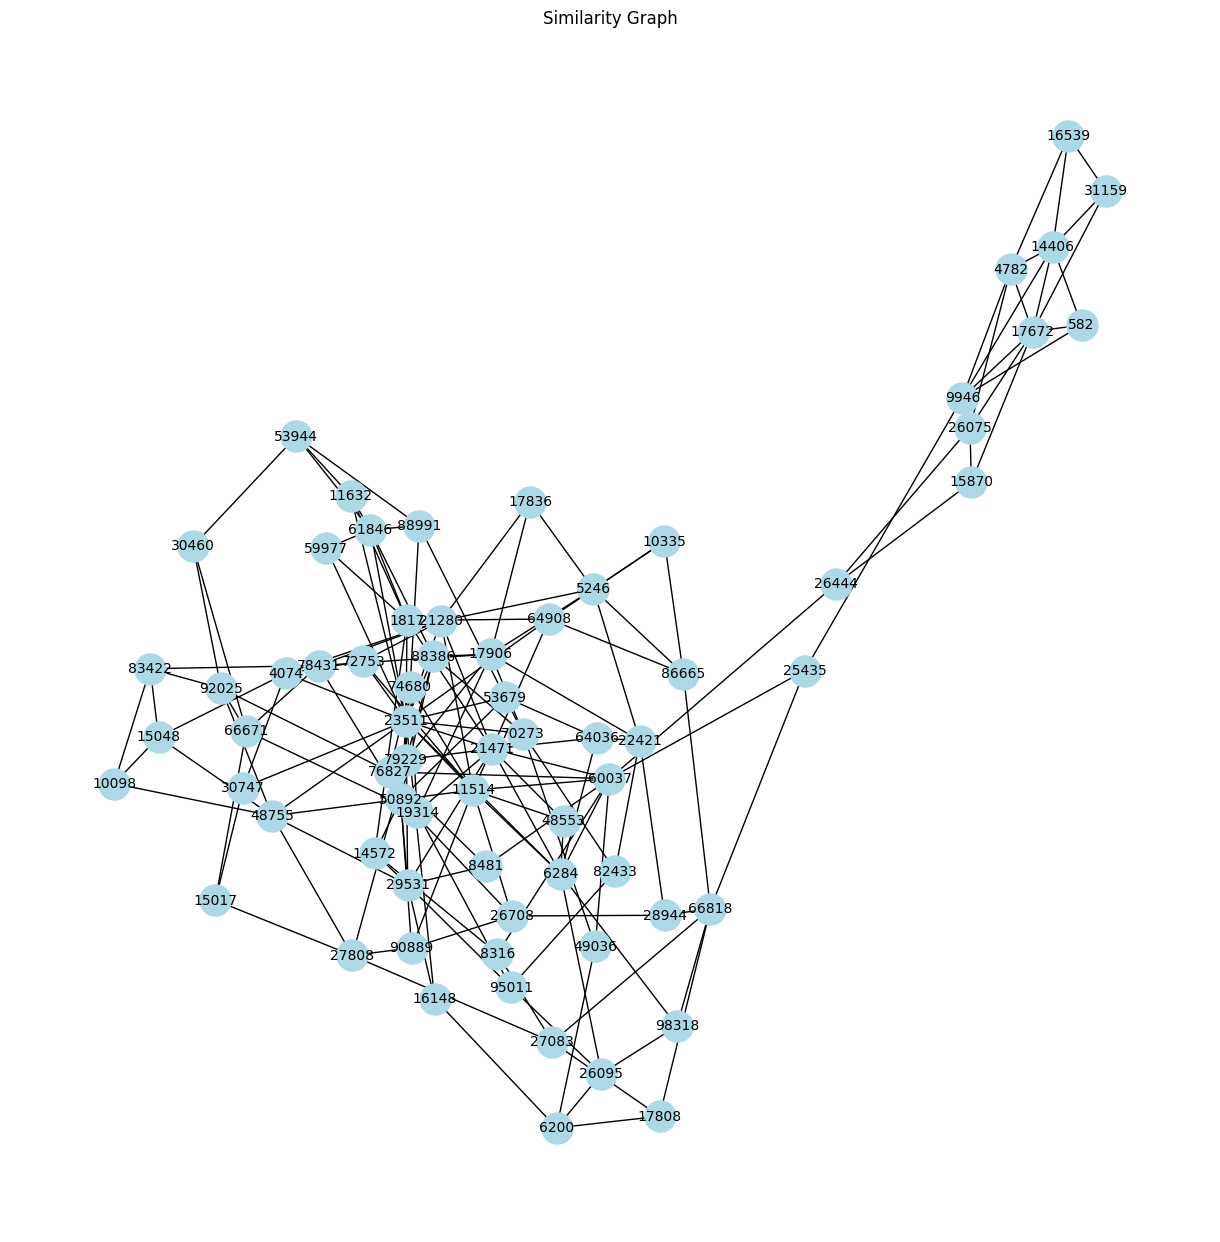

In [19]:
# convert top_n_df to a networkx graph
import networkx as nx

# Create a new graph
G_sim = nx.Graph()

# Add nodes for each patient
for i, row in top_n_df.iterrows():
    G_sim.add_node(int(row['PATIENT_ID']), similarity=row['SIMILARITY_SCORE'])

# Add edges between patients based on diagnosis
for i, row in top_n_df.iterrows():
    for j in range(1, top_n + 1):
        patient_id = int(row[f"TOP_{j}_PATIENT_ID"])
        G_sim.add_edge(int(row['PATIENT_ID']), patient_id, similarity=row['SIMILARITY_SCORE'])

# Print the number of nodes and edges in the graph
print(f"Number of nodes in the similarity graph: {G_sim.number_of_nodes()}")
print(f"Number of edges in the similarity graph: {G_sim.number_of_edges()}")

# Draw the graph using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
nx.draw(G_sim, with_labels=True, node_size=500, node_color="lightblue", font_size=10)
plt.title("Similarity Graph")
plt.show()


## Create Similarity Pyvis Graph

In [ ]:
# use pyvis to draw the graph
from pyvis.network import Network

# convert G_sim to a pyvis graph
nt_sim = Network(height="1200px", width="100%", notebook=False, directed=False, cdn_resources="remote")
nt_sim.from_nx(G_sim)

# add node attributes to the pyvis network
for node in nt_sim.nodes:
    node['title'] = f"Patient ID: {node['id']}\nSimilarity: {node['similarity']}"
    node['label'] = f"{node['id']}"
    node['font'] = {'size': 5}
# add edge attributes to the pyvis network

for edge in nt_sim.edges:
    edge['title'] = f"Similarity: {edge['similarity']}"
    edge['label'] = f"{edge['similarity']}"
    # set font size to 5
    edge['font'] = {'size': 5}

print("added nx graph to pyvis network")
print(f"file name: {HTML_SIMILARITY_FILE_NAME}")
nt_sim.toggle_physics(False)
nt_sim.show_buttons()
nt_sim.generate_html(HTML_SIMILARITY_FILE_NAME)
nt_sim.save_graph(HTML_SIMILARITY_FILE_NAME)
print("saved pyvis graph to file")


added nx graph to pyvis network
file name: d:\Repos\ut-health-final-proj\pyvis\graph_max_100_nodes.html_sim


AssertionError: d:\Repos\ut-health-final-proj\pyvis\graph_max_100_nodes.html_sim is not a valid html file